# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

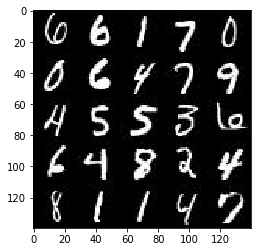

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

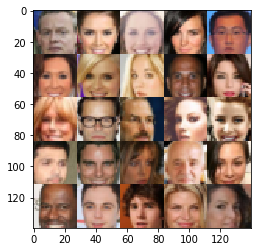

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x<out_channel_dim> now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    steps = 0
    show_every = 100
    print_every = 10
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    losses = []
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # scale real images to be values between -1 <-> 1
                batch_images = batch_images * 2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3441... Generator Loss: 1.9406
Epoch 1/2... Discriminator Loss: 0.8603... Generator Loss: 2.1338
Epoch 1/2... Discriminator Loss: 2.3024... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 2.4713... Generator Loss: 0.2766
Epoch 1/2... Discriminator Loss: 2.3099... Generator Loss: 0.2310
Epoch 1/2... Discriminator Loss: 2.1902... Generator Loss: 0.1962
Epoch 1/2... Discriminator Loss: 1.9856... Generator Loss: 0.2430
Epoch 1/2... Discriminator Loss: 1.9276... Generator Loss: 0.4403
Epoch 1/2... Discriminator Loss: 1.9747... Generator Loss: 0.2252
Epoch 1/2... Discriminator Loss: 1.6633... Generator Loss: 0.6332


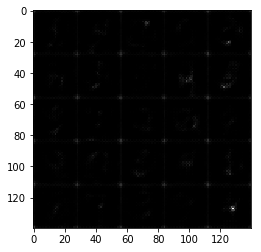

Epoch 1/2... Discriminator Loss: 1.8314... Generator Loss: 0.2936
Epoch 1/2... Discriminator Loss: 1.6260... Generator Loss: 0.3886
Epoch 1/2... Discriminator Loss: 1.8049... Generator Loss: 0.2798
Epoch 1/2... Discriminator Loss: 1.5325... Generator Loss: 0.5813
Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 0.5170
Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 0.4430
Epoch 1/2... Discriminator Loss: 1.6179... Generator Loss: 0.3853
Epoch 1/2... Discriminator Loss: 1.5563... Generator Loss: 0.4483
Epoch 1/2... Discriminator Loss: 1.5011... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 1.6934... Generator Loss: 0.3856


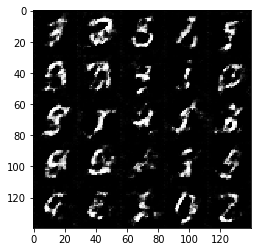

Epoch 1/2... Discriminator Loss: 1.5403... Generator Loss: 0.8708
Epoch 1/2... Discriminator Loss: 1.7168... Generator Loss: 0.2827
Epoch 1/2... Discriminator Loss: 1.7089... Generator Loss: 0.3011
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 1.6626... Generator Loss: 0.3644
Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 0.6088
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.8294... Generator Loss: 0.2497
Epoch 1/2... Discriminator Loss: 1.5123... Generator Loss: 0.6765


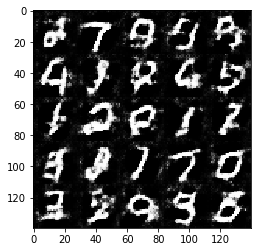

Epoch 1/2... Discriminator Loss: 1.6931... Generator Loss: 0.3729
Epoch 1/2... Discriminator Loss: 1.6765... Generator Loss: 0.3696
Epoch 1/2... Discriminator Loss: 1.9077... Generator Loss: 0.2104
Epoch 1/2... Discriminator Loss: 1.7156... Generator Loss: 0.2875
Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 1.5638... Generator Loss: 0.4474
Epoch 1/2... Discriminator Loss: 1.4929... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.7760... Generator Loss: 0.2676
Epoch 1/2... Discriminator Loss: 1.5972... Generator Loss: 0.4094
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 0.5306


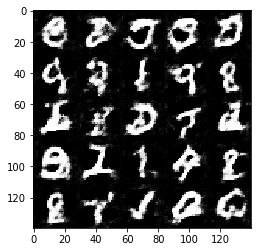

Epoch 1/2... Discriminator Loss: 1.8491... Generator Loss: 0.2384
Epoch 1/2... Discriminator Loss: 1.5799... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 1.6724... Generator Loss: 0.3010
Epoch 1/2... Discriminator Loss: 1.6192... Generator Loss: 0.3623
Epoch 1/2... Discriminator Loss: 1.4913... Generator Loss: 0.4730
Epoch 1/2... Discriminator Loss: 1.4743... Generator Loss: 0.5291
Epoch 1/2... Discriminator Loss: 1.5265... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 1.4872... Generator Loss: 0.5598
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.5227


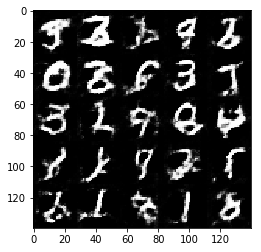

Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 1.7114... Generator Loss: 0.3862
Epoch 1/2... Discriminator Loss: 1.6364... Generator Loss: 0.3521
Epoch 1/2... Discriminator Loss: 1.5106... Generator Loss: 0.6844
Epoch 1/2... Discriminator Loss: 1.4982... Generator Loss: 0.5503
Epoch 1/2... Discriminator Loss: 1.5307... Generator Loss: 0.5881
Epoch 1/2... Discriminator Loss: 1.5604... Generator Loss: 0.9839
Epoch 1/2... Discriminator Loss: 1.4974... Generator Loss: 0.5146
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.6390
Epoch 1/2... Discriminator Loss: 1.5048... Generator Loss: 0.6429


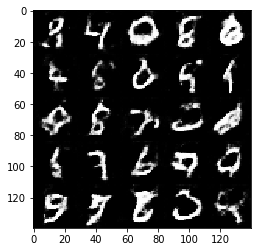

Epoch 1/2... Discriminator Loss: 1.5007... Generator Loss: 0.7610
Epoch 1/2... Discriminator Loss: 1.5865... Generator Loss: 0.3737
Epoch 1/2... Discriminator Loss: 1.7023... Generator Loss: 0.3015
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 0.3800
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.6548... Generator Loss: 0.3002
Epoch 1/2... Discriminator Loss: 1.4301... Generator Loss: 0.4714
Epoch 1/2... Discriminator Loss: 1.5670... Generator Loss: 0.3964


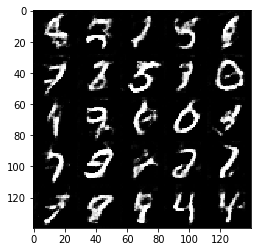

Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.4528
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.6106
Epoch 1/2... Discriminator Loss: 1.5402... Generator Loss: 0.4444
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.5510
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 0.5929
Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.5638
Epoch 1/2... Discriminator Loss: 1.6429... Generator Loss: 0.3134
Epoch 1/2... Discriminator Loss: 1.6274... Generator Loss: 0.3031
Epoch 1/2... Discriminator Loss: 1.6882... Generator Loss: 0.2753
Epoch 1/2... Discriminator Loss: 1.6407... Generator Loss: 0.3120


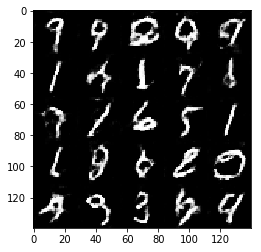

Epoch 1/2... Discriminator Loss: 1.6950... Generator Loss: 0.3179
Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 0.3312
Epoch 1/2... Discriminator Loss: 1.5928... Generator Loss: 0.8865
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.5316
Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 0.6280
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.6674
Epoch 1/2... Discriminator Loss: 1.9439... Generator Loss: 1.3992
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.7047
Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 0.4408
Epoch 1/2... Discriminator Loss: 1.5269... Generator Loss: 0.4034


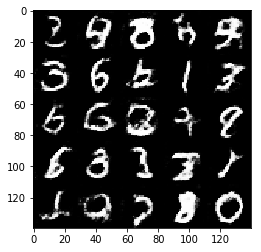

Epoch 1/2... Discriminator Loss: 1.5852... Generator Loss: 0.3487
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 0.5198
Epoch 1/2... Discriminator Loss: 1.6012... Generator Loss: 0.8703
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.4449
Epoch 2/2... Discriminator Loss: 1.4999... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 1.7811... Generator Loss: 0.2557
Epoch 2/2... Discriminator Loss: 1.4790... Generator Loss: 0.4407
Epoch 2/2... Discriminator Loss: 1.4184... Generator Loss: 0.8486
Epoch 2/2... Discriminator Loss: 1.6923... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.5669


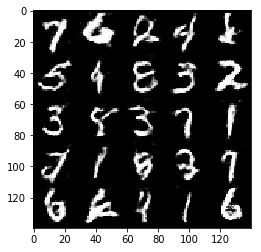

Epoch 2/2... Discriminator Loss: 1.5196... Generator Loss: 0.3590
Epoch 2/2... Discriminator Loss: 1.5840... Generator Loss: 0.3862
Epoch 2/2... Discriminator Loss: 1.4918... Generator Loss: 0.4718
Epoch 2/2... Discriminator Loss: 1.3276... Generator Loss: 0.7195
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.4190
Epoch 2/2... Discriminator Loss: 1.8934... Generator Loss: 0.2046
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.6535
Epoch 2/2... Discriminator Loss: 1.4493... Generator Loss: 0.3865
Epoch 2/2... Discriminator Loss: 1.4579... Generator Loss: 0.5053


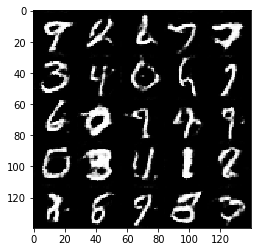

Epoch 2/2... Discriminator Loss: 1.8094... Generator Loss: 0.2437
Epoch 2/2... Discriminator Loss: 1.4988... Generator Loss: 0.3787
Epoch 2/2... Discriminator Loss: 1.4432... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.5296
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.4509
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.5018
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 1.4928... Generator Loss: 0.3526
Epoch 2/2... Discriminator Loss: 1.6049... Generator Loss: 0.3279
Epoch 2/2... Discriminator Loss: 1.6263... Generator Loss: 0.3970


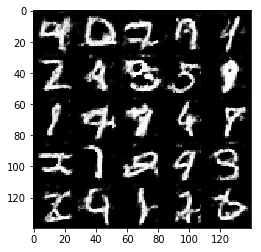

Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.4945
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.5747
Epoch 2/2... Discriminator Loss: 1.5229... Generator Loss: 0.4009
Epoch 2/2... Discriminator Loss: 1.6208... Generator Loss: 0.3142
Epoch 2/2... Discriminator Loss: 1.5229... Generator Loss: 0.4326
Epoch 2/2... Discriminator Loss: 1.8214... Generator Loss: 0.2466
Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 0.4899
Epoch 2/2... Discriminator Loss: 1.5114... Generator Loss: 0.4263
Epoch 2/2... Discriminator Loss: 1.5729... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 0.4894


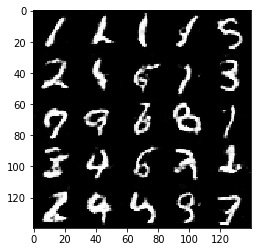

Epoch 2/2... Discriminator Loss: 1.5046... Generator Loss: 0.3858
Epoch 2/2... Discriminator Loss: 1.6649... Generator Loss: 0.3045
Epoch 2/2... Discriminator Loss: 1.7239... Generator Loss: 0.2566
Epoch 2/2... Discriminator Loss: 1.8095... Generator Loss: 0.2856
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.7322
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.4468
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 1.4576... Generator Loss: 0.4385
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.5595
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.5815


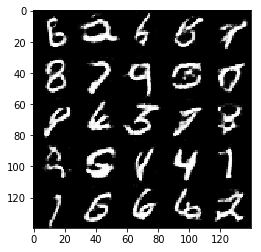

Epoch 2/2... Discriminator Loss: 1.7195... Generator Loss: 0.2570
Epoch 2/2... Discriminator Loss: 1.4727... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.2806... Generator Loss: 0.5871
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 0.4689
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.4469
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.6760
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.4914
Epoch 2/2... Discriminator Loss: 1.3325... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.4254


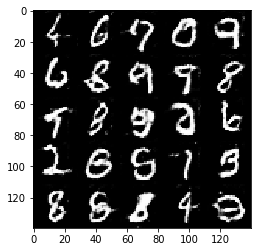

Epoch 2/2... Discriminator Loss: 1.5005... Generator Loss: 0.4055
Epoch 2/2... Discriminator Loss: 1.5323... Generator Loss: 0.3600
Epoch 2/2... Discriminator Loss: 1.6769... Generator Loss: 0.3299
Epoch 2/2... Discriminator Loss: 1.4142... Generator Loss: 0.4062
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 0.6859
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.5655
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 1.0396
Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 0.6145
Epoch 2/2... Discriminator Loss: 1.4584... Generator Loss: 0.4071
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.3783


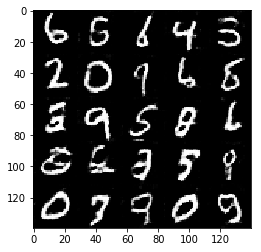

Epoch 2/2... Discriminator Loss: 1.5786... Generator Loss: 0.3640
Epoch 2/2... Discriminator Loss: 1.6823... Generator Loss: 0.3269
Epoch 2/2... Discriminator Loss: 1.3208... Generator Loss: 0.4917
Epoch 2/2... Discriminator Loss: 1.6326... Generator Loss: 0.3551
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.4813
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.4838
Epoch 2/2... Discriminator Loss: 1.4852... Generator Loss: 0.3417
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.4590
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 0.5046
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 0.9181


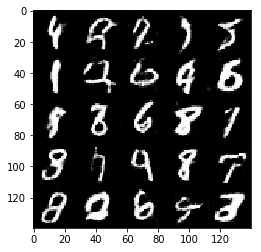

Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 0.6675
Epoch 2/2... Discriminator Loss: 1.1402... Generator Loss: 0.6679
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.5393
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.6520
Epoch 2/2... Discriminator Loss: 1.0643... Generator Loss: 0.8662
Epoch 2/2... Discriminator Loss: 1.4533... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 1.6935... Generator Loss: 0.2730
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.6055
Epoch 2/2... Discriminator Loss: 1.5808... Generator Loss: 0.3144


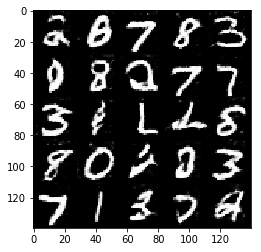

Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 0.4401
Epoch 2/2... Discriminator Loss: 1.1859... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 1.2209... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.4567... Generator Loss: 0.3772
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.5274
Epoch 2/2... Discriminator Loss: 1.5691... Generator Loss: 0.4040
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.5807


In [25]:
batch_size = 64
z_dim = 120
learning_rate = 0.0002
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 2.5586... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 2.5815... Generator Loss: 0.2607
Epoch 1/1... Discriminator Loss: 2.2709... Generator Loss: 0.4169
Epoch 1/1... Discriminator Loss: 1.6795... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.4488
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 3.1750
Epoch 1/1... Discriminator Loss: 2.3109... Generator Loss: 0.1528
Epoch 1/1... Discriminator Loss: 2.0328... Generator Loss: 0.2026
Epoch 1/1... Discriminator Loss: 1.9288... Generator Loss: 0.2602


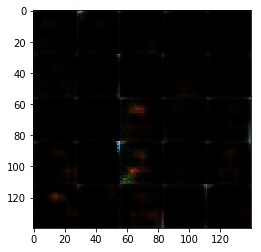

Epoch 1/1... Discriminator Loss: 2.0204... Generator Loss: 0.2970
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 2.1755... Generator Loss: 0.1825
Epoch 1/1... Discriminator Loss: 2.0451... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 1.9688... Generator Loss: 0.4565
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.6610... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.7737... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.8460... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.8958... Generator Loss: 0.4487


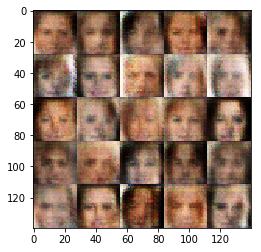

Epoch 1/1... Discriminator Loss: 1.8226... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.7263... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.7781... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.6726... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.6202... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.5783... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.5799


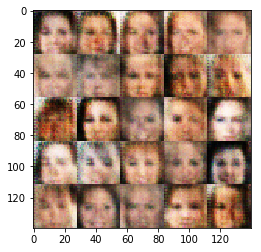

Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.6353


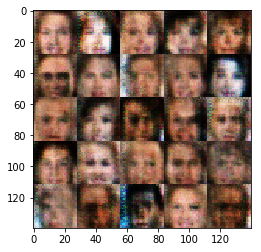

Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6147


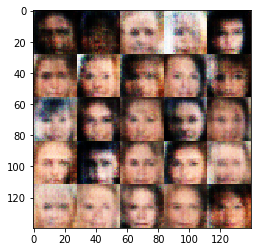

Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6252


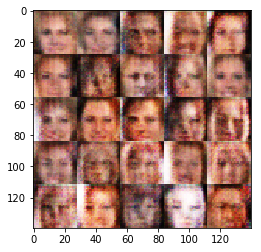

Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6711


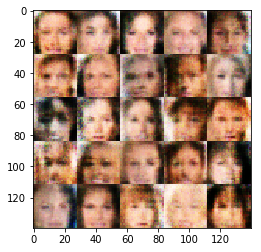

Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7033


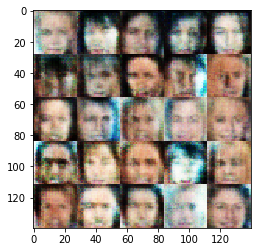

Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.5877


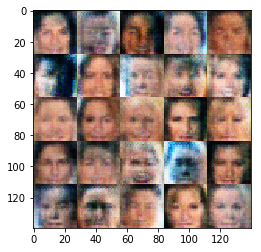

Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.6612


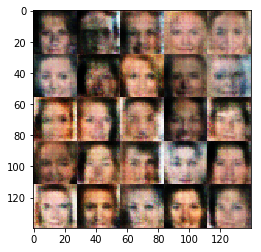

Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7042


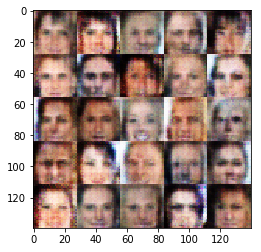

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6292


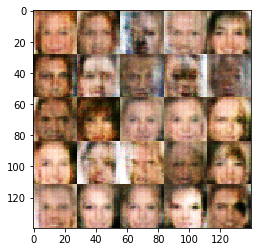

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6934


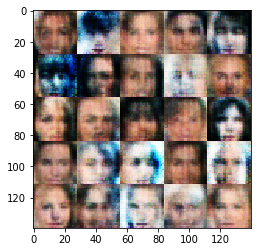

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6791


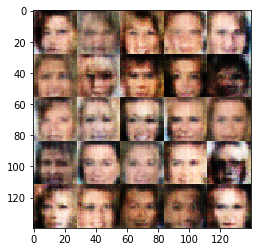

Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7407


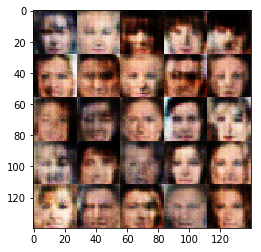

Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6688


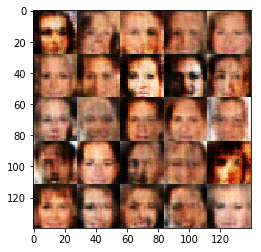

Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6225


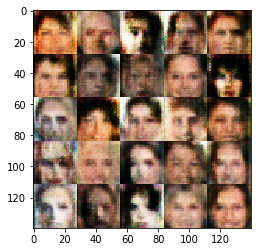

Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6226


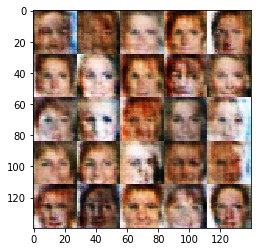

Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6095


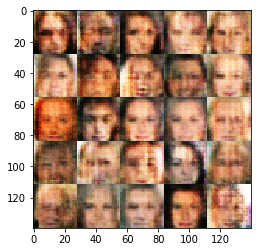

Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.6365


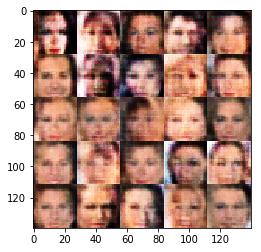

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7569


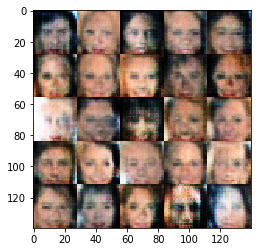

Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6664


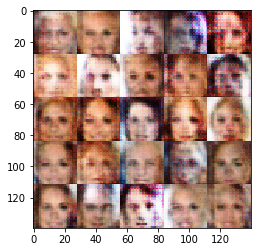

Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6331


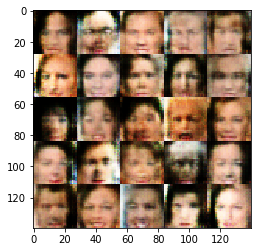

Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.6231


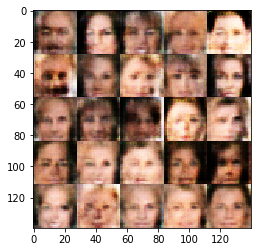

Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6438


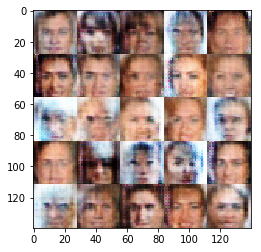

Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6470


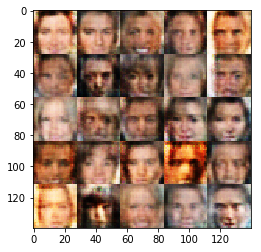

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6498


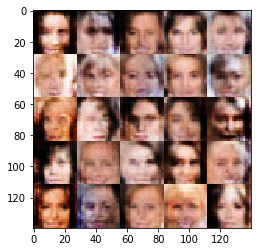

Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6492


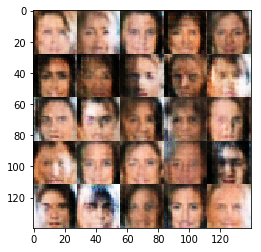

Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.5946


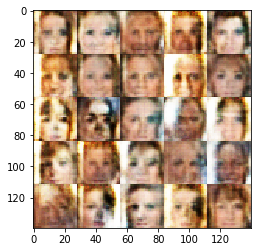

Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7053


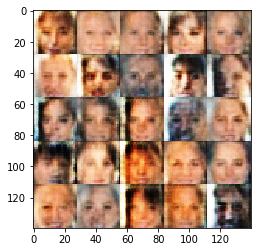

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7837


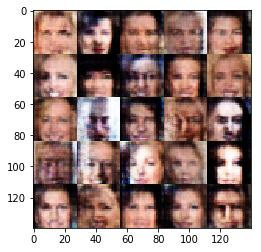

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.5570


In [26]:
batch_size = 64
z_dim = 120
learning_rate = 0.0004
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.